In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install prophet
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

In [32]:
df = pd.read_csv("Time_series_analysis_and_forecast_DATASET.csv")
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [33]:
df["FullDate"] = pd.to_datetime(df["FullDate"])
df = df.set_index(df["FullDate"])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.2 MB


In [34]:
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,,
2010-09-01 00:00:00,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [6]:
df.isnull().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

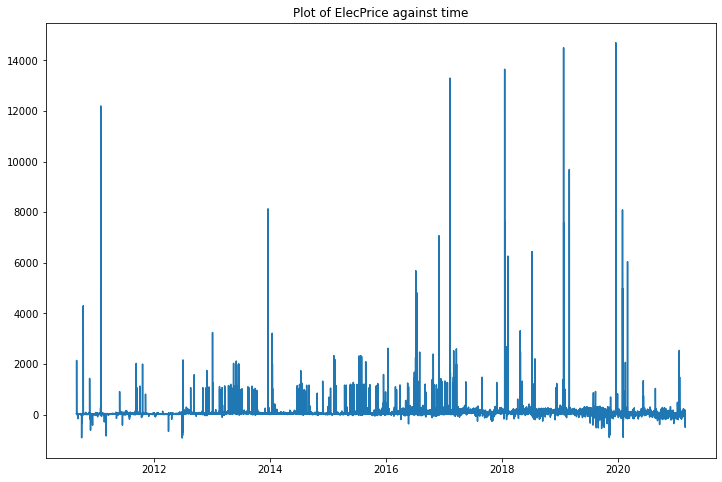

In [9]:
plt.figure(figsize = (12, 8))
plt.plot(df["ElecPrice"])
plt.title("Plot of ElecPrice against time");

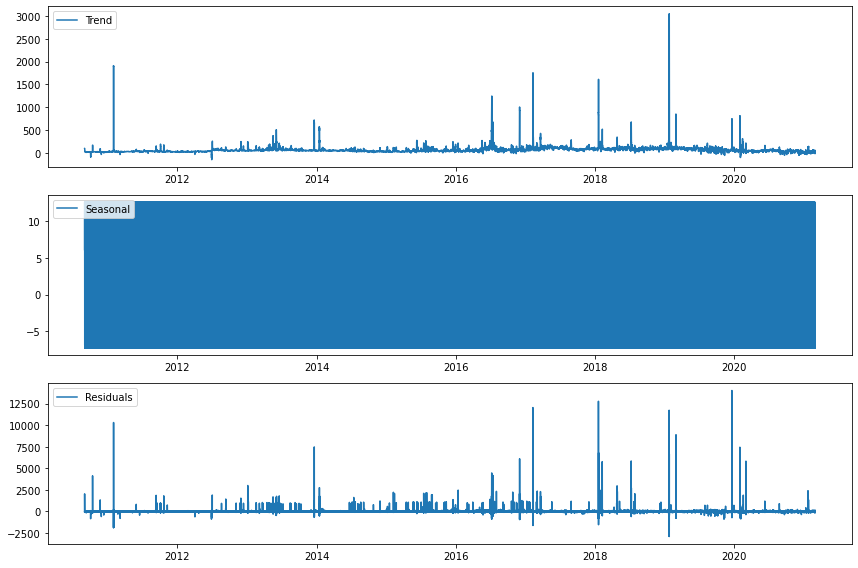

In [10]:
decomposition = sm.tsa.seasonal_decompose(df["ElecPrice"], model="addictive", period=30)
trend = decomposition.trend
residual = decomposition.resid
seasonal = decomposition.seasonal

plt.figure(figsize = (12, 8))
plt.subplot(3, 1, 1)
plt.plot(trend, label = "Trend")
plt.legend(loc="upper left")

plt.subplot(3, 1, 2)
plt.plot(seasonal, label = "Seasonal")
plt.legend(loc="upper left")

plt.subplot(3, 1, 3)
plt.plot(residual, label = "Residuals")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [11]:
# Calculating the p-value for SysLoad and Gas Price
result = adfuller(df["SysLoad"])
result1 = adfuller(df["GasPrice"])
print(f"ADF stats for Sysload is {result[1]} and Gas Price is {result1[1]}")

ADF stats for Sysload is 2.4474966090684217e-30 and Gas Price is 2.333760534364015e-09


In [12]:
print("Critical value:")
for key, value in result1[4].items():
    print(f' {key} : {value}')

Critical value:
 1% : -3.430421106837576
 5% : -2.86157142807793
 10% : -2.566786728071412


In [13]:
# Calculating ADF stats, p-value, and critical values for ElecPrice
result2 = adfuller(df["ElecPrice"])
#print("ADF stats:", result[0])
#print("p-value:", result[1])
print("Critical value:")
for key, value in result2[4].items():
    print(f' {key} : {value}')

Critical value:
 1% : -3.430421110703783
 5% : -2.8615714297867108
 10% : -2.56678672898094


In [14]:
# Making a copy of df
df_uni = df.copy()
# Preparing dataset for univariate time series analysis
df_uni = df_uni[["FullDate", "ElecPrice"]]
# Resampling dataset from hourly to daily
df_uni = df_uni.resample("D").sum()
# Splitting dataset into train and test
train = df_uni[:2757]
test = df_uni[2757:]
train.shape, test.shape

((2757, 1), (1077, 1))

In [15]:
# Renaming dataset 
prophet_data = pd.DataFrame({"ds": train.index, "y": train["ElecPrice"]})
prophet_data.head()

,ds,y
FullDate,,
2010-09-01,2010-09-01,2751.700
2010-09-02,2010-09-02,570.810
2010-09-03,2010-09-03,504.975
2010-09-04,2010-09-04,502.275
2010-09-05,2010-09-05,500.555


In [16]:
# Building and fitting data to Prophet model
model = Prophet()
model.fit(prophet_data)
#Creating a dataframe for predictions
future = model.make_future_dataframe(periods = len(test))
#Forecast future predictions
forecast = model.predict(future)
forecast_test = forecast['yhat'].tail(len(test))
forecast_test.head()

20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing


2757    2528.359123
2758    2681.646415
2759    2780.638040
2760    2572.764875
2761    2247.980991
Name: yhat, dtype: float64

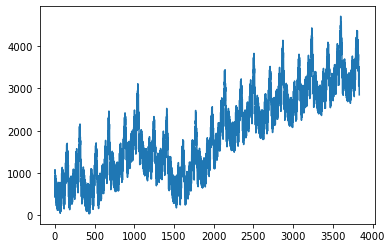

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3599,2020-07-09,3352.180648,2009.373877,7485.426964,2122.594517,4527.423182,1349.443965,1349.443965,1349.443965,257.112222,257.112222,257.112222,1092.331743,1092.331743,1092.331743,0.0,0.0,0.0,4701.624613


In [17]:
# plot to show the month of the yearly seasonality that has the highest value?
plt.plot(forecast["yhat"])
plt.show();
print()
# Getting the value
forecast[forecast["yhat"] == forecast["yhat"].max()]

In [18]:
# Importing libraries to evaluate performance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#Mean absolute percentage error
mape = mean_absolute_percentage_error(test["ElecPrice"], forecast_test)
print(f"MAPE: {mape}")

# mean square error
mse = mean_squared_error(test["ElecPrice"], forecast_test)

#Root mean square error
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

MAPE: 5.444572645744382
RMSE: 3207.7722194126754


#### Multivariate time series forecast

In [44]:
df.head()

,Tmax,SysLoad,GasPrice,y
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [46]:
# Resampling multivariate time series 
df = df.resample("D").sum()
df = pd.DataFrame({'ds': df.index, 'Tmax': df['Tmax'], 'SysLoad': df['SysLoad'], 'GasPrice': df['GasPrice'], "ElecPrice": df['y']})
# Splitting dataset into train and test
train = df[:2757]
test = df[2757:]

df.head(3)

,ds,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,,
2010-09-01,2010-09-01,379.2,41565.38,88.56,2751.700
2010-09-02,2010-09-02,369.6,38898.99,88.56,570.810
2010-09-03,2010-09-03,439.2,41665.76,106.80,504.975


In [47]:
df.rename(columns = {"ElecPrice": "y"}, inplace=True)
df.head(2)

,ds,Tmax,SysLoad,GasPrice,y
FullDate,,,,,
2010-09-01,2010-09-01,379.2,41565.38,88.56,2751.70
2010-09-02,2010-09-02,369.6,38898.99,88.56,570.81


In [49]:
#Build and fit model for multivariate time series
model = Prophet(interval_width=0.9)
model.add_regressor("Tmax", standardize=False)
model.add_regressor("SysLoad", standardize=False)
model.add_regressor("GasPrice", standardize=False)
model.fit(df)

#Creting a dataframe for predictions
future_mul = model.make_future_dataframe(periods = len(test))

#Forecast future predictions
forecast_mul = model.predict(future_mul)

forecast_test_mul = forecast_mul['yhat'].tail(len(test_mul))

20:50:04 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing
20:50:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:50:07 - cmdstanpy - INFO - Chain [1] start processing

KeyboardInterrupt



In [ ]:
forecast_test_mul.head()

In [ ]:
forecast_testte error
mae_mul = mean_absolute_error(test_mul["ElecPrice"], forecast_test_mul)
print(f"MAE: {mae_mul}")

#Mean absolute percentage error
mape_mul = mean_absolute_percentage_error(test_mul["ElecPrice"], forecast_test_mul)
print(f"MAPE: {mape_mul}")

# mean square error
mse_mul = mean_squared_error(test_mul["ElecPrice"], forecast_test_mul)
print(f"MSE: {mse_mul}")

#Root mean square error
rmse_mul = np.sqrt(mse_mul)
print(f"RMSE: {rmse_mul}")

In [ ]:
forecast_mul.head()

In [ ]:
forecast_mul[forecast_mul["yhat"] == forecast_mul["yhat"].max()]

In [ ]:
forecast_mul["yhat"].max()

In [ ]:
prophet_data_mul = pd.DataFrame({"ds": train_mul.index, "add1": train_mul["SysLoad"], "add3": train_mul["GasPrice"], "y": train_mul["ElecPrice"]})
prophet_data_mul

model = Prophet()
model.fit(prophet_data_mul)

#Creting a dataframe for predictions
future_mul = model.make_future_dataframe(periods = len(test_mul))

#Forecast future predictions
forecast_mul = model.predict(future_mul)

forecast_test_mul = forecast_mul['yhat'].tail(len(test_mul))

mape_mul = mean_absolute_percentage_error(test_mul["ElecPrice"], forecast_test_mul)
print(f"MAPE: {mape_mul}")
